### **코드 구동 전에 꼭 주석해제하고 설치해주세요! 설치 후에는 주석 처리 권장**

In [2]:
# !pip show scipy
# !pip install nltk
# !pip install pandas
# !pip install contractions
# import nltk # 수정 감사합니다~
# nltk.download('punkt') # 오래 걸림..
# nltk.download('omw-1.4')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# !pip install pyLDAvis
# !pip install gensim
# !pip install scikit-learn

### 사용 라이브러리들

In [4]:
import re
import os
import nltk
import string
import gensim
import pyLDAvis
import numpy as np
import contractions
import pandas as pd
from tqdm import tqdm
from collections import Counter
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pyLDAvis.gensim as gensimvis
from matplotlib import pyplot as plt
from gensim import corpora, models
from gensim.models import doc2vec
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.models.doc2vec import TaggedDocument
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None) # Pandas 전체 열 확인
pd.set_option('display.max_rows', None) # Pandas 전체 행 확인

### 1. 데이터 로딩

In [6]:
# df = pd.read_csv("./LDA-Workspace/1. Data/Flipkart/df_LG_refri.csv") # 로드할 데이터의 (상대 or 절대) 경로를 지정
# df = pd.read_csv("./1. Data/Amazon/Amazon_LG_TV_review.csv") # 로드할 데이터의 (상대 or 절대) 경로를 지정
df = pd.read_csv("./1. Data/Flipkart/LG_total.csv") # 로드할 데이터의 (상대 or 절대) 경로를 지정
df_original = df
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data
0,0,0,Waste of money . AC not working till one month...,"Certified Buyer, Alwar","May, 2023",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....
1,1,1,I purchased this LG A. C. on 17 April 23..The ...,"Certified Buyer, Kalyan","Apr, 2023",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....
2,2,2,If you want to buy a white showpiece for your ...,"Certified Buyer, Madhyamgram","Apr, 2023",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....
3,3,3,Totally waste of money. company is not refund ...,"Certified Buyer, Charkhi Dadri","May, 2022",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....
4,4,4,"This model don't have 4 way swing, it's actual...","Certified Buyer, Erode",6 months ago,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....


#### 옵션) 별점, 지역 등을 기준으로 필터링하실 분들은 아래에 코드 추가해서 진행 바랍니다

In [8]:
# df = df[df["star"] == 5] # 예시. 별점으로 분류할 경우
# df.head()

### 2. 데이터 전처리
1. 결측 데이터 여부 확인
1-2. 결측 데이터 확인시 다른 데이터(공백이나 0 등)로 대체
2. 이모지 제거 -> 텍스트 전처리 시작
3. 소문자 변환 
4. 수축형 확장
5. 구두점 제거
6. 불용어 제거
7. 표제어 추출
8. 단일 글자 제거
9. 숫자 제거

---
- 특정 데이터만 전처리를 원할 경우 코드 수정해서 사용해주세요! (예. df['특정열'])

In [10]:
# 로딩한 데이터 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5052 entries, 0 to 5051
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  5052 non-null   int64 
 1   Unnamed: 0    5052 non-null   int64 
 2   text          5052 non-null   object
 3   state         5052 non-null   object
 4   date          5052 non-null   object
 5   star          5052 non-null   int64 
 6   hp_data       5052 non-null   object
dtypes: int64(3), object(4)
memory usage: 276.4+ KB


#### 1) 결측 데이터 여부 확인

In [12]:
df.isnull().sum()

Unnamed: 0.1    0
Unnamed: 0      0
text            0
state           0
date            0
star            0
hp_data         0
dtype: int64

#### 1-2) 결측 데이터 대체
- 임시 방안

In [14]:
df = df.fillna('') # 결측치가 있는 경우
df.isnull().sum() # 결측치 데이터 여부 재확인

Unnamed: 0.1    0
Unnamed: 0      0
text            0
state           0
date            0
star            0
hp_data         0
dtype: int64

#### 2) 이모지 제거
- 영어 제외 언어들도 제거?
  - 아스키(American ~) 코드를 기준으로 제거했기 때문에 다른 언어들도 함께 제거되는 것으로 추정

In [16]:
# 텍스트에서 이모지를 제거하는 함수
# 아스키 코드로 변환 후 제거
def rmEmoji_ascii(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

# DataFrame의 모든 문자열에 적용
def df_remove_emoji(df):
    return df.map(lambda x: rmEmoji_ascii(x) if isinstance(x, str) else x)

In [17]:
# Before
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data
0,0,0,Waste of money . AC not working till one month...,"Certified Buyer, Alwar","May, 2023",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....
1,1,1,I purchased this LG A. C. on 17 April 23..The ...,"Certified Buyer, Kalyan","Apr, 2023",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....
2,2,2,If you want to buy a white showpiece for your ...,"Certified Buyer, Madhyamgram","Apr, 2023",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....
3,3,3,Totally waste of money. company is not refund ...,"Certified Buyer, Charkhi Dadri","May, 2022",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....
4,4,4,"This model don't have 4 way swing, it's actual...","Certified Buyer, Erode",6 months ago,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....


In [18]:
# After
df = df_remove_emoji(df)
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data
0,0,0,Waste of money . AC not working till one month...,"Certified Buyer, Alwar","May, 2023",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....
1,1,1,I purchased this LG A. C. on 17 April 23..The ...,"Certified Buyer, Kalyan","Apr, 2023",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....
2,2,2,If you want to buy a white showpiece for your ...,"Certified Buyer, Madhyamgram","Apr, 2023",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....
3,3,3,Totally waste of money. company is not refund ...,"Certified Buyer, Charkhi Dadri","May, 2022",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....
4,4,4,"This model don't have 4 way swing, it's actual...","Certified Buyer, Erode",6 months ago,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....


#### 3) 소문자 변환

In [20]:
# DataFrame의 모든 열에 대해 문자열을 소문자로 변환하는 함수
# 문자열이 아닌 경우는 그대로 유지
def df_lowercase(df):
    return df.map(lambda x: x.lower() if isinstance(x, str) else x)

In [21]:
# Before
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data
0,0,0,Waste of money . AC not working till one month...,"Certified Buyer, Alwar","May, 2023",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....
1,1,1,I purchased this LG A. C. on 17 April 23..The ...,"Certified Buyer, Kalyan","Apr, 2023",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....
2,2,2,If you want to buy a white showpiece for your ...,"Certified Buyer, Madhyamgram","Apr, 2023",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....
3,3,3,Totally waste of money. company is not refund ...,"Certified Buyer, Charkhi Dadri","May, 2022",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....
4,4,4,"This model don't have 4 way swing, it's actual...","Certified Buyer, Erode",6 months ago,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....


In [22]:
# After
df = df_lowercase(df)
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data
0,0,0,waste of money . ac not working till one month...,"certified buyer, alwar","may, 2023",1,lg ai convertible 6-in-1 cooling 2024 model 1....
1,1,1,i purchased this lg a. c. on 17 april 23..the ...,"certified buyer, kalyan","apr, 2023",1,lg ai convertible 6-in-1 cooling 2024 model 1....
2,2,2,if you want to buy a white showpiece for your ...,"certified buyer, madhyamgram","apr, 2023",1,lg ai convertible 6-in-1 cooling 2024 model 1....
3,3,3,totally waste of money. company is not refund ...,"certified buyer, charkhi dadri","may, 2022",1,lg ai convertible 6-in-1 cooling 2024 model 1....
4,4,4,"this model don't have 4 way swing, it's actual...","certified buyer, erode",6 months ago,1,lg ai convertible 6-in-1 cooling 2024 model 1....


#### 4) 수축형 확장
- don't -> do not, aren't -> are not, etc 

In [24]:
# DataFrame의 모든 문자열 열에서 수축형을 확장하는 함수.
# 문자열이 아닌 경우는 그대로 유지
def df_expand_contractions(df):
     return df.map(lambda x: contractions.fix(x) if isinstance(x, str) else x)

In [25]:
# Before
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data
0,0,0,waste of money . ac not working till one month...,"certified buyer, alwar","may, 2023",1,lg ai convertible 6-in-1 cooling 2024 model 1....
1,1,1,i purchased this lg a. c. on 17 april 23..the ...,"certified buyer, kalyan","apr, 2023",1,lg ai convertible 6-in-1 cooling 2024 model 1....
2,2,2,if you want to buy a white showpiece for your ...,"certified buyer, madhyamgram","apr, 2023",1,lg ai convertible 6-in-1 cooling 2024 model 1....
3,3,3,totally waste of money. company is not refund ...,"certified buyer, charkhi dadri","may, 2022",1,lg ai convertible 6-in-1 cooling 2024 model 1....
4,4,4,"this model don't have 4 way swing, it's actual...","certified buyer, erode",6 months ago,1,lg ai convertible 6-in-1 cooling 2024 model 1....


In [26]:
# After
df = df_expand_contractions(df)
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data
0,0,0,waste of money . ac not working till one month...,"certified buyer, alwar","may, 2023",1,lg ai convertible 6-in-1 cooling 2024 model 1....
1,1,1,i purchased this lg a. c. on 17 april 23..the ...,"certified buyer, kalyan","apr, 2023",1,lg ai convertible 6-in-1 cooling 2024 model 1....
2,2,2,if you want to buy a white showpiece for your ...,"certified buyer, madhyamgram","apr, 2023",1,lg ai convertible 6-in-1 cooling 2024 model 1....
3,3,3,totally waste of money. company is not refund ...,"certified buyer, charkhi dadri","may, 2022",1,lg ai convertible 6-in-1 cooling 2024 model 1....
4,4,4,"this model do not have 4 way swing, it is actu...","certified buyer, erode",6 months ago,1,lg ai convertible 6-in-1 cooling 2024 model 1....


#### 5) 구두점 제거
- ?,!. 과 같이 텍스트 분석에 불필요한 요소들 제거
- 필요시, 해당 부분은 일부 데이터를 제외하고 적용되도록 수정해서 사용 요망..(날짜, 모델명 등)

In [28]:
def df_remove_punctuation(df):
    return df.map(lambda x: x.translate(str.maketrans('', '', string.punctuation)) if isinstance(x, str) else x)

In [29]:
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data
0,0,0,waste of money . ac not working till one month...,"certified buyer, alwar","may, 2023",1,lg ai convertible 6-in-1 cooling 2024 model 1....
1,1,1,i purchased this lg a. c. on 17 april 23..the ...,"certified buyer, kalyan","apr, 2023",1,lg ai convertible 6-in-1 cooling 2024 model 1....
2,2,2,if you want to buy a white showpiece for your ...,"certified buyer, madhyamgram","apr, 2023",1,lg ai convertible 6-in-1 cooling 2024 model 1....
3,3,3,totally waste of money. company is not refund ...,"certified buyer, charkhi dadri","may, 2022",1,lg ai convertible 6-in-1 cooling 2024 model 1....
4,4,4,"this model do not have 4 way swing, it is actu...","certified buyer, erode",6 months ago,1,lg ai convertible 6-in-1 cooling 2024 model 1....


In [30]:
df = df_remove_punctuation(df)
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data
0,0,0,waste of money ac not working till one month ...,certified buyer alwar,may 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
1,1,1,i purchased this lg a c on 17 april 23the most...,certified buyer kalyan,apr 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
2,2,2,if you want to buy a white showpiece for your ...,certified buyer madhyamgram,apr 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
3,3,3,totally waste of money company is not refund m...,certified buyer charkhi dadri,may 2022,1,lg ai convertible 6in1 cooling 2024 model 15 t...
4,4,4,this model do not have 4 way swing it is actua...,certified buyer erode,6 months ago,1,lg ai convertible 6in1 cooling 2024 model 15 t...


#### 6) 불용어 제거
- nltk 불용어 사전 적용

In [32]:
# Before
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data
0,0,0,waste of money ac not working till one month ...,certified buyer alwar,may 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
1,1,1,i purchased this lg a c on 17 april 23the most...,certified buyer kalyan,apr 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
2,2,2,if you want to buy a white showpiece for your ...,certified buyer madhyamgram,apr 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
3,3,3,totally waste of money company is not refund m...,certified buyer charkhi dadri,may 2022,1,lg ai convertible 6in1 cooling 2024 model 15 t...
4,4,4,this model do not have 4 way swing it is actua...,certified buyer erode,6 months ago,1,lg ai convertible 6in1 cooling 2024 model 15 t...


In [33]:
# 불용어 목록 가져오기
stop_words = set(stopwords.words('english'))

In [34]:
# 불용어 제거 함수
def remove_stopwords(text):
    if isinstance(text, str):
        words = word_tokenize(text)  # 텍스트를 단어로 토큰화
        filtered_words = [word for word in words if word.lower() not in stop_words]  # 불용어 제거
        return ' '.join(filtered_words)  # 필터링된 단어들을 다시 하나의 문자열로 결합
    else:
        return text  # 문자열이 아닌 경우 그대로 반환

def df_remove_stopwords(df):
    return df.map(remove_stopwords)

In [35]:
# Before
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data
0,0,0,waste of money ac not working till one month ...,certified buyer alwar,may 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
1,1,1,i purchased this lg a c on 17 april 23the most...,certified buyer kalyan,apr 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
2,2,2,if you want to buy a white showpiece for your ...,certified buyer madhyamgram,apr 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
3,3,3,totally waste of money company is not refund m...,certified buyer charkhi dadri,may 2022,1,lg ai convertible 6in1 cooling 2024 model 15 t...
4,4,4,this model do not have 4 way swing it is actua...,certified buyer erode,6 months ago,1,lg ai convertible 6in1 cooling 2024 model 15 t...


In [36]:
# After
df = df_remove_stopwords(df)
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data
0,0,0,waste money ac working till one month installa...,certified buyer alwar,may 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
1,1,1,purchased lg c 17 april 23the horrible experie...,certified buyer kalyan,apr 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
2,2,2,want buy white showpiece bedroom go ahead othe...,certified buyer madhyamgram,apr 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
3,3,3,totally waste money company refund money per p...,certified buyer charkhi dadri,may 2022,1,lg ai convertible 6in1 cooling 2024 model 15 t...
4,4,4,model 4 way swing actual ton 13 cooling capaci...,certified buyer erode,6 months ago,1,lg ai convertible 6in1 cooling 2024 model 15 t...


#### 7) 표제어 추출
- 단어 원형 추출
  - children -> child, went -> go, etc

In [38]:
# nltk의 pos_tag와 wordnet의 태그 매핑 함수
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# 모든 문자열에 대해 표제어 추출을 수행하는 함수
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer() # 텍스트를 토큰화
    tokens = word_tokenize(text) # 품사 태깅
    tagged_tokens = nltk.pos_tag(tokens) # 각 단어를 표제어 추출 (품사 정보 고려)
    lemmatized_tokens = []
    for token, tag in tagged_tokens:
        wordnet_pos = get_wordnet_pos(tag) or wordnet.NOUN  # 기본적으로 명사 처리
        lemmatized_tokens.append(lemmatizer.lemmatize(token, pos=wordnet_pos))
    return ' '.join(lemmatized_tokens)

# DataFrame의 모든 문자열에 대해 lemmatize_text 함수 수행
# 문자열이 아닌 경우는 그대로 유지
def df_lemmatize(df):
    return df.map(lambda x: lemmatize_text(x) if isinstance(x, str) else x)

In [39]:
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data
0,0,0,waste money ac working till one month installa...,certified buyer alwar,may 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
1,1,1,purchased lg c 17 april 23the horrible experie...,certified buyer kalyan,apr 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
2,2,2,want buy white showpiece bedroom go ahead othe...,certified buyer madhyamgram,apr 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
3,3,3,totally waste money company refund money per p...,certified buyer charkhi dadri,may 2022,1,lg ai convertible 6in1 cooling 2024 model 15 t...
4,4,4,model 4 way swing actual ton 13 cooling capaci...,certified buyer erode,6 months ago,1,lg ai convertible 6in1 cooling 2024 model 15 t...


In [40]:
# After
df = df_lemmatize(df)
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data
0,0,0,waste money ac work till one month installatio...,certify buyer alwar,may 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
1,1,1,purchase lg c 17 april 23the horrible experien...,certify buyer kalyan,apr 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
2,2,2,want buy white showpiece bedroom go ahead othe...,certify buyer madhyamgram,apr 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
3,3,3,totally waste money company refund money per p...,certify buyer charkhi dadri,may 2022,1,lg ai convertible 6in1 cooling 2024 model 15 t...
4,4,4,model 4 way swing actual ton 13 cooling capaci...,certify buyer erode,6 month ago,1,lg ai convertible 6in1 cooling 2024 model 15 t...


#### 8) 숫자 데이터 제거
- 마찬가지로 필요시 해당 부분은 일부 데이터를 제외하고 적용되도록 수정해서 사용 요망..(날짜, 모델명 등)

In [42]:
# 숫자 제거 함수
def remove_numbers_from_text(text):
    cleaned_text = re.sub(r'\d+', '', text) # 숫자를 제거
    
    # 중복된 공백 제거 및 텍스트 정리
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text if cleaned_text else ""

def df_remove_numbers(df):
    return df.map(lambda x: remove_numbers_from_text(x) if isinstance(x, str) else x)

In [43]:
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data
0,0,0,waste money ac work till one month installatio...,certify buyer alwar,may 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
1,1,1,purchase lg c 17 april 23the horrible experien...,certify buyer kalyan,apr 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
2,2,2,want buy white showpiece bedroom go ahead othe...,certify buyer madhyamgram,apr 2023,1,lg ai convertible 6in1 cooling 2024 model 15 t...
3,3,3,totally waste money company refund money per p...,certify buyer charkhi dadri,may 2022,1,lg ai convertible 6in1 cooling 2024 model 15 t...
4,4,4,model 4 way swing actual ton 13 cooling capaci...,certify buyer erode,6 month ago,1,lg ai convertible 6in1 cooling 2024 model 15 t...


In [44]:
df = df_remove_numbers(df)
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data
0,0,0,waste money ac work till one month installatio...,certify buyer alwar,may,1,lg ai convertible in cooling model ton star sp...
1,1,1,purchase lg c april the horrible experience ev...,certify buyer kalyan,apr,1,lg ai convertible in cooling model ton star sp...
2,2,2,want buy white showpiece bedroom go ahead othe...,certify buyer madhyamgram,apr,1,lg ai convertible in cooling model ton star sp...
3,3,3,totally waste money company refund money per p...,certify buyer charkhi dadri,may,1,lg ai convertible in cooling model ton star sp...
4,4,4,model way swing actual ton cooling capacity w ...,certify buyer erode,month ago,1,lg ai convertible in cooling model ton star sp...


#### 9) 의미 없는 단일 글자 데이터 제거

In [46]:
# 정규 표현식을 사용하여 한 글자 단어를 제거
def remove_single_characters(text):
    cleaned_text = re.sub(r'\b\w{1}\b', '', text)
    # 중복된 공백 제거
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

# 마찬가지로 DataFrame에 적용
def df_remove_single_characters(df):
    return df.map(lambda x: remove_single_characters(x) if isinstance(x, str) else x)

In [47]:
# Before
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data
0,0,0,waste money ac work till one month installatio...,certify buyer alwar,may,1,lg ai convertible in cooling model ton star sp...
1,1,1,purchase lg c april the horrible experience ev...,certify buyer kalyan,apr,1,lg ai convertible in cooling model ton star sp...
2,2,2,want buy white showpiece bedroom go ahead othe...,certify buyer madhyamgram,apr,1,lg ai convertible in cooling model ton star sp...
3,3,3,totally waste money company refund money per p...,certify buyer charkhi dadri,may,1,lg ai convertible in cooling model ton star sp...
4,4,4,model way swing actual ton cooling capacity w ...,certify buyer erode,month ago,1,lg ai convertible in cooling model ton star sp...


In [48]:
# After
df = df_remove_single_characters(df)
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data
0,0,0,waste money ac work till one month installatio...,certify buyer alwar,may,1,lg ai convertible in cooling model ton star sp...
1,1,1,purchase lg april the horrible experience ever...,certify buyer kalyan,apr,1,lg ai convertible in cooling model ton star sp...
2,2,2,want buy white showpiece bedroom go ahead othe...,certify buyer madhyamgram,apr,1,lg ai convertible in cooling model ton star sp...
3,3,3,totally waste money company refund money per p...,certify buyer charkhi dadri,may,1,lg ai convertible in cooling model ton star sp...
4,4,4,model way swing actual ton cooling capacity ch...,certify buyer erode,month ago,1,lg ai convertible in cooling model ton star sp...


#### 옵션) 특정 단어들을 제외하고 싶을 경우
- +) 특정 품사만 추출하고파! -> 표제어 추출 함수 응용하면 될지도..?
- 표제어 추출이 일부 미흡

In [50]:
# 예시 코드
# stop_words.update(['lg','flipkart']) # 불용어 사전 업데이트 
# df = df_remove_stopwords(df)
# df.head()

### 3. 텍스트 데이터 토큰화

In [52]:
# 텍스트를 토큰화하는 함수
def tokenize_text(text):
    
    return word_tokenize(text)

# DataFrame의 모든 문자열을 토큰화하는 함수.
def df_tokenize(df):
    return df.map(lambda x: tokenize_text(x) if isinstance(x, str) else x)

In [53]:
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data
0,0,0,waste money ac work till one month installatio...,certify buyer alwar,may,1,lg ai convertible in cooling model ton star sp...
1,1,1,purchase lg april the horrible experience ever...,certify buyer kalyan,apr,1,lg ai convertible in cooling model ton star sp...
2,2,2,want buy white showpiece bedroom go ahead othe...,certify buyer madhyamgram,apr,1,lg ai convertible in cooling model ton star sp...
3,3,3,totally waste money company refund money per p...,certify buyer charkhi dadri,may,1,lg ai convertible in cooling model ton star sp...
4,4,4,model way swing actual ton cooling capacity ch...,certify buyer erode,month ago,1,lg ai convertible in cooling model ton star sp...


In [54]:
df = df_tokenize(df)
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data
0,0,0,"[waste, money, ac, work, till, one, month, ins...","[certify, buyer, alwar]",[may],1,"[lg, ai, convertible, in, cooling, model, ton,..."
1,1,1,"[purchase, lg, april, the, horrible, experienc...","[certify, buyer, kalyan]",[apr],1,"[lg, ai, convertible, in, cooling, model, ton,..."
2,2,2,"[want, buy, white, showpiece, bedroom, go, ahe...","[certify, buyer, madhyamgram]",[apr],1,"[lg, ai, convertible, in, cooling, model, ton,..."
3,3,3,"[totally, waste, money, company, refund, money...","[certify, buyer, charkhi, dadri]",[may],1,"[lg, ai, convertible, in, cooling, model, ton,..."
4,4,4,"[model, way, swing, actual, ton, cooling, capa...","[certify, buyer, erode]","[month, ago]",1,"[lg, ai, convertible, in, cooling, model, ton,..."


#### 추가) 차후 원본 텍스트 비교 위해 원본 텍스트 컬럼 추가

In [56]:
df['original'] = df_original['text']
df.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data,original
0,0,0,"[waste, money, ac, work, till, one, month, ins...","[certify, buyer, alwar]",[may],1,"[lg, ai, convertible, in, cooling, model, ton,...",Waste of money . AC not working till one month...
1,1,1,"[purchase, lg, april, the, horrible, experienc...","[certify, buyer, kalyan]",[apr],1,"[lg, ai, convertible, in, cooling, model, ton,...",I purchased this LG A. C. on 17 April 23..The ...
2,2,2,"[want, buy, white, showpiece, bedroom, go, ahe...","[certify, buyer, madhyamgram]",[apr],1,"[lg, ai, convertible, in, cooling, model, ton,...",If you want to buy a white showpiece for your ...
3,3,3,"[totally, waste, money, company, refund, money...","[certify, buyer, charkhi, dadri]",[may],1,"[lg, ai, convertible, in, cooling, model, ton,...",Totally waste of money. company is not refund ...
4,4,4,"[model, way, swing, actual, ton, cooling, capa...","[certify, buyer, erode]","[month, ago]",1,"[lg, ai, convertible, in, cooling, model, ton,...","This model don't have 4 way swing, it's actual..."


### 4. 클러스터 선정

#### ✨분석 및 벡터화 진행할 텍스트 데이터 열 선택

In [59]:
column_name = "text" # 분석 진행할 텍스트 데이터 열 선택
display(df.head()) # 열 이름 확인용

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data,original
0,0,0,"[waste, money, ac, work, till, one, month, ins...","[certify, buyer, alwar]",[may],1,"[lg, ai, convertible, in, cooling, model, ton,...",Waste of money . AC not working till one month...
1,1,1,"[purchase, lg, april, the, horrible, experienc...","[certify, buyer, kalyan]",[apr],1,"[lg, ai, convertible, in, cooling, model, ton,...",I purchased this LG A. C. on 17 April 23..The ...
2,2,2,"[want, buy, white, showpiece, bedroom, go, ahe...","[certify, buyer, madhyamgram]",[apr],1,"[lg, ai, convertible, in, cooling, model, ton,...",If you want to buy a white showpiece for your ...
3,3,3,"[totally, waste, money, company, refund, money...","[certify, buyer, charkhi, dadri]",[may],1,"[lg, ai, convertible, in, cooling, model, ton,...",Totally waste of money. company is not refund ...
4,4,4,"[model, way, swing, actual, ton, cooling, capa...","[certify, buyer, erode]","[month, ago]",1,"[lg, ai, convertible, in, cooling, model, ton,...","This model don't have 4 way swing, it's actual..."


#### 1) 벡터화
- TD-IDF Vectorization

In [61]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X = tfidf_vectorizer.fit_transform(df[f'{column_name}'].apply(lambda x: ' '.join(x)))

#### 2) Elbow Method
- 최적의 K 값 탐색

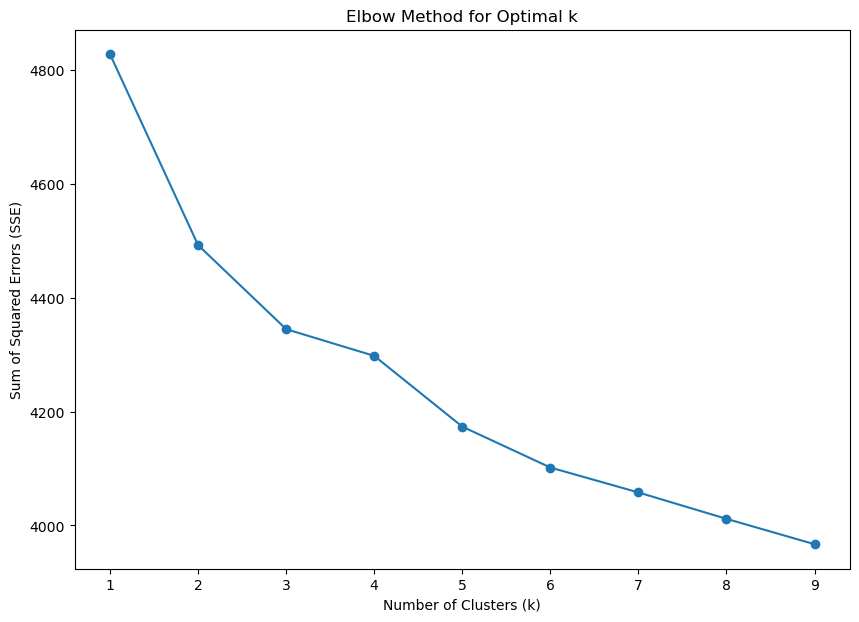

In [63]:
sse = []
k_values = range(1, 10)  # 클러스터 개수 1에서 9까지 실험

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)  # SSE 값을 추가

# Elbow Plot
plt.figure(figsize=(10, 7))
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()

#### 3) K-Means Clustering
- Elbow Method로 찾은 K 값 적용 후 클러스터링

In [65]:
num_clusters = 4  # 원하는 클러스터 수
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init = 10)
df['cluster'] = kmeans.fit_predict(X)

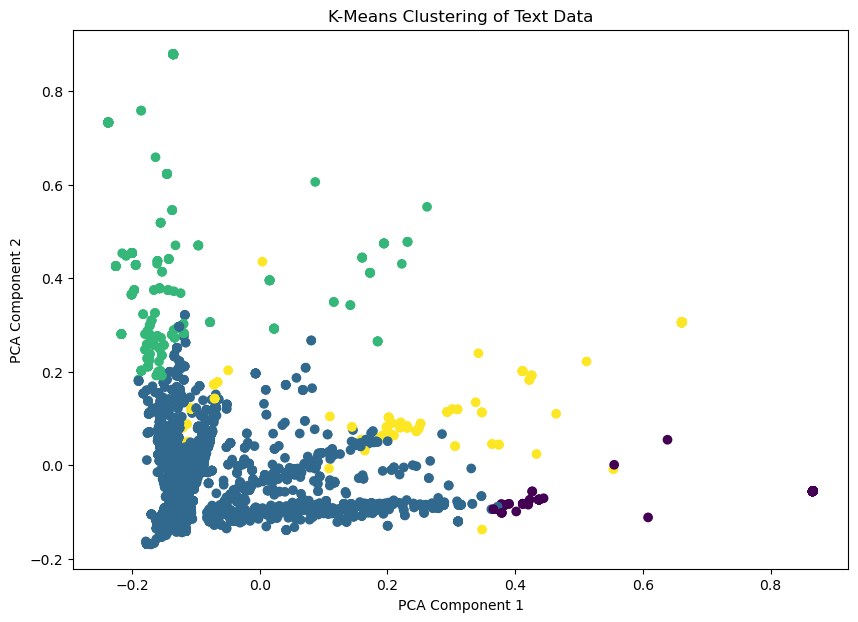

In [66]:
# 결과 시각화 (PCA로 차원 축소)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 7))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=df['cluster'], cmap='viridis')
plt.title('K-Means Clustering of Text Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [67]:
# 클러스터링 결과 출력
print(df[[f'{column_name}', 'cluster']])

                                                   text  cluster
0     [waste, money, ac, work, till, one, month, ins...        1
1     [purchase, lg, april, the, horrible, experienc...        1
2     [want, buy, white, showpiece, bedroom, go, ahe...        1
3     [totally, waste, money, company, refund, money...        1
4     [model, way, swing, actual, ton, cooling, capa...        1
5     [buy, product, flipkart, cool, ac, remote, sto...        1
6     [bad, service, flipkart, jeeves, wrong, instll...        1
7                          [ac, get, temperature, less]        1
8           [watter, leek, outdoor, pipe, line, indoor]        1
9                     [third, class, ac, slow, cooling]        1
10      [give, cool, instent, cool, satisfied, product]        1
11                              [please, buy, ac, cool]        1
12            [energy, efficient, per, company, spoken]        1
13     [installation, good, water, lekeage, issue, day]        1
14    [work, week, cool, 

In [68]:
# 분석 진행할 문자열 컬럼을 리스트에서 문자열로 변환
df_temp = df.copy()
df_temp[f'{column_name}'] = df_temp[f'{column_name}'].apply(lambda x: ' '.join(x))

In [69]:
# 각 클러스터별 단어 빈도 계산
terms = tfidf_vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

In [70]:
# 각 클러스터별 상위 단어 추출 및 빈도수 계산
# num_terms = (상위 단어 수)
def get_top_terms_per_cluster(num_terms=10):
    cluster_term_dict = {}
    
    for cluster_num in range(4):
        print(f"\nCluster {cluster_num} Top Terms:")
        cluster_docs = df_temp[df_temp['cluster'] == cluster_num][f'{column_name}']  # 클러스터에 속한 문서들
        term_counts = {}
        
        for doc in cluster_docs:
            for term in doc.split():  # 문자열을 단어로 나누기
                if term in term_counts:
                    term_counts[term] += 1
                else:
                    term_counts[term] = 1
        
        top_terms = sorted(term_counts.items(), key=lambda item: item[1], reverse=True)[:num_terms]
        cluster_term_dict[cluster_num] = top_terms
        print(top_terms)
    
    return cluster_term_dict

top_terms_per_cluster = get_top_terms_per_cluster(num_terms=10)


Cluster 0 Top Terms:
[('good', 381), ('quality', 16), ('cool', 5), ('item', 4), ('picture', 4), ('ac', 3), ('design', 3), ('tv', 3), ('work', 3), ('go', 2)]

Cluster 1 Top Terms:
[('product', 1145), ('good', 1012), ('lg', 714), ('buy', 644), ('cool', 606), ('bad', 577), ('ac', 520), ('quality', 514), ('flipkart', 505), ('tv', 478)]

Cluster 2 Top Terms:
[('bad', 479), ('product', 217), ('experience', 70), ('quality', 68), ('cool', 52), ('good', 48), ('service', 43), ('lg', 38), ('installation', 37), ('buy', 37)]

Cluster 3 Top Terms:
[('product', 312), ('good', 233), ('nice', 79), ('poor', 14), ('value', 13), ('money', 13), ('buy', 11), ('flipkart', 10), ('lg', 10), ('service', 10)]


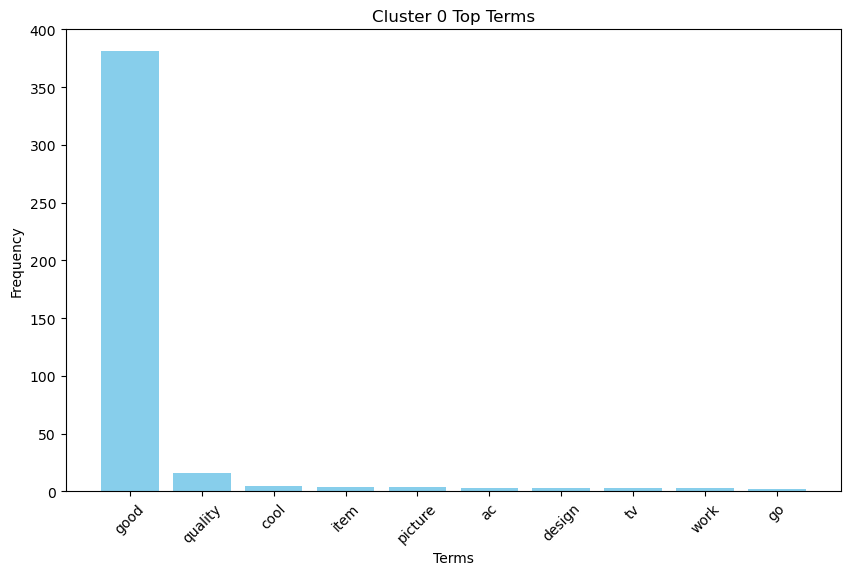

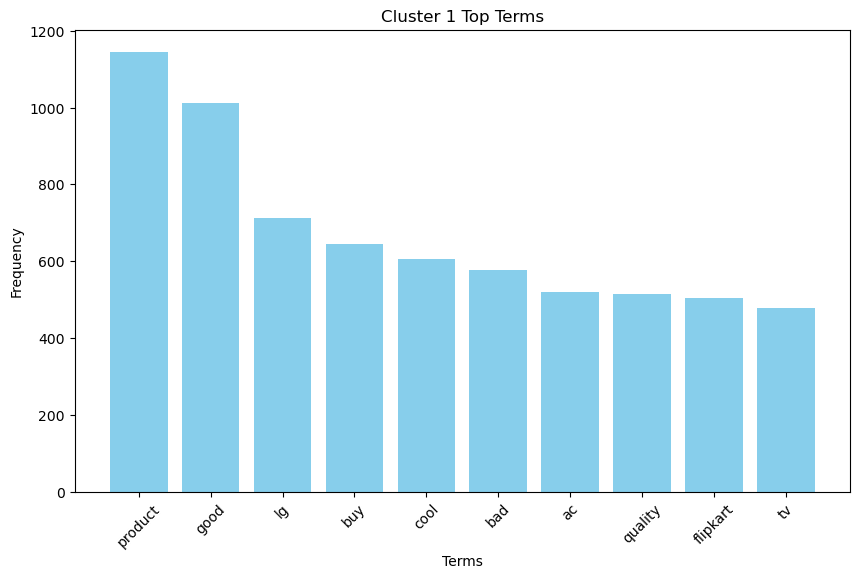

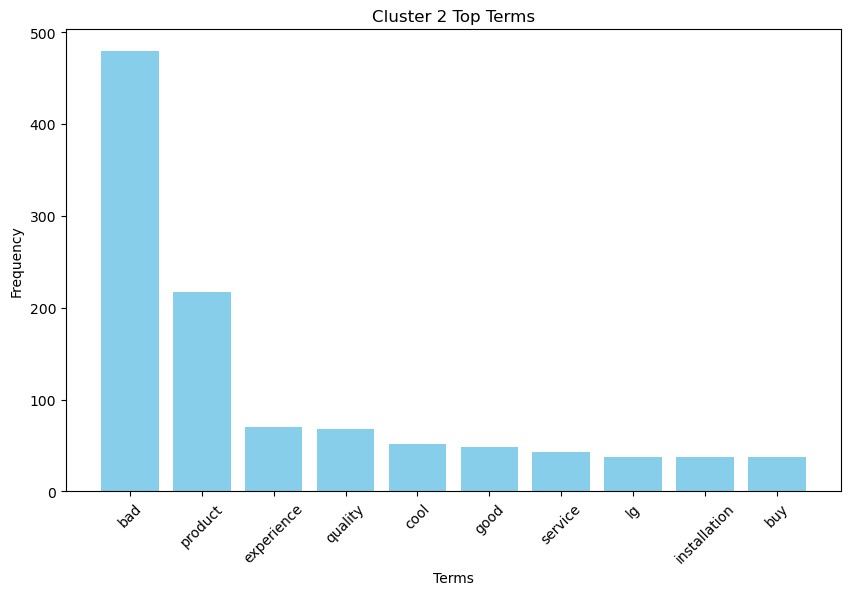

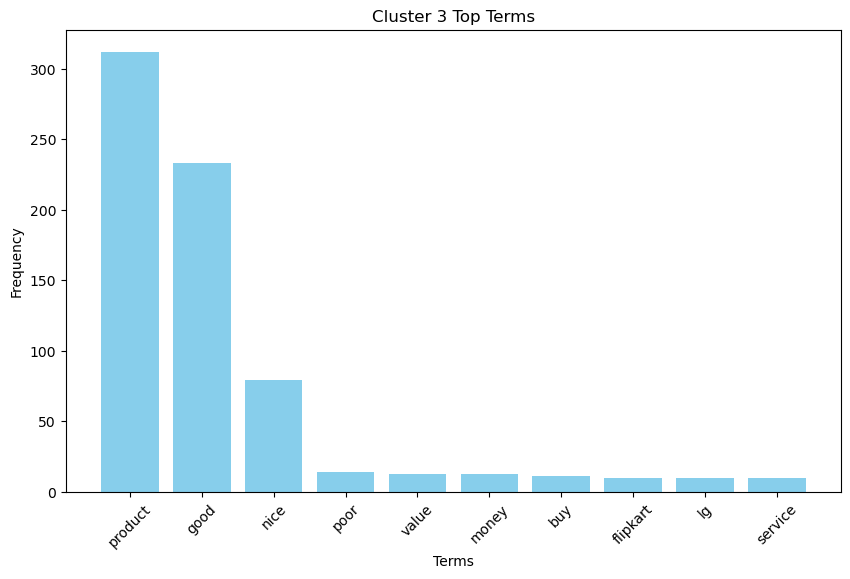

In [71]:
# 클러스터별 상위 단어 바 그래프
def plot_top_terms_per_cluster(cluster_term_dict):
    for cluster_num, terms in cluster_term_dict.items():
        terms, frequencies = zip(*terms)  # 단어와 빈도를 분리
        
        plt.figure(figsize=(10, 6))
        plt.bar(terms, frequencies, color='skyblue')
        plt.title(f'Cluster {cluster_num} Top Terms')
        plt.xlabel('Terms')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.show()

plot_top_terms_per_cluster(top_terms_per_cluster)

### 5. LDA 분석
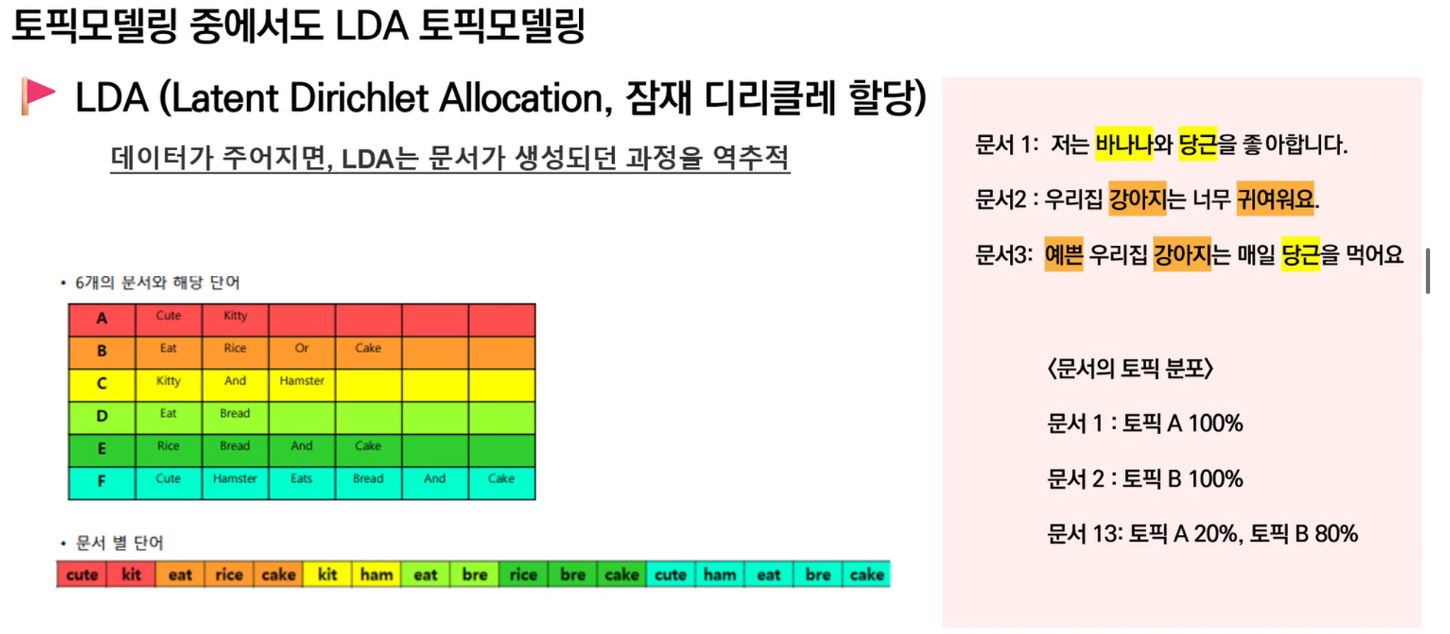

#### ✨✨분석 진행할 클러스터 선정
- 클러스터 선정 파트에서 분석한 데이터를 기반으로! 여기서 최종적으로 LDA 분석 진행할 클러스터 선정!!
- 해당 코드는 예시로 0번째 클러스터를 선택
- 만약 클러스터 분류 없이 바로 LDA 분석을 진행하고 싶으시다면 '4. 클러스터 선정'을 건너띄고 df_cluster = df.copy()로 아래 코드 수정 후에 진행하시면 됩니다. 

In [74]:
df_cluster = df[df['cluster']==1].copy() # 참고 : https://emilkwak.github.io/pandas-dataframe-settingwithcopywarning
df_cluster.head()

,Unnamed: 0.1,Unnamed: 0,text,state,date,star,hp_data,original,cluster
0,0,0,"[waste, money, ac, work, till, one, month, ins...","[certify, buyer, alwar]",[may],1,"[lg, ai, convertible, in, cooling, model, ton,...",Waste of money . AC not working till one month...,1
1,1,1,"[purchase, lg, april, the, horrible, experienc...","[certify, buyer, kalyan]",[apr],1,"[lg, ai, convertible, in, cooling, model, ton,...",I purchased this LG A. C. on 17 April 23..The ...,1
2,2,2,"[want, buy, white, showpiece, bedroom, go, ahe...","[certify, buyer, madhyamgram]",[apr],1,"[lg, ai, convertible, in, cooling, model, ton,...",If you want to buy a white showpiece for your ...,1
3,3,3,"[totally, waste, money, company, refund, money...","[certify, buyer, charkhi, dadri]",[may],1,"[lg, ai, convertible, in, cooling, model, ton,...",Totally waste of money. company is not refund ...,1
4,4,4,"[model, way, swing, actual, ton, cooling, capa...","[certify, buyer, erode]","[month, ago]",1,"[lg, ai, convertible, in, cooling, model, ton,...","This model don't have 4 way swing, it's actual...",1


#### 1) 전체 단어의 사전 만들고 각 문서에 매칭
- 코드 그대로 따라했는데 각 문서에 매칭한다는 내용은 잘 모르겠어요

In [76]:
all_documents=list(df_cluster[f'{column_name}']) # 'text' 컬럼 지정
dictionary=Dictionary(all_documents)
# dictionary.token2id # 확인용

In [77]:
corpus=[]
for doc in all_documents:
    corpus.append(dictionary.doc2bow(doc))
corpus[0] #ID 값, 빈도

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 2),
 (13, 1),
 (14, 2),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 2),
 (19, 1)]

#### 2) LDA 모델 만들기

##### 2-1) LDA 토픽개수 선정
-  perplexcity & coherence
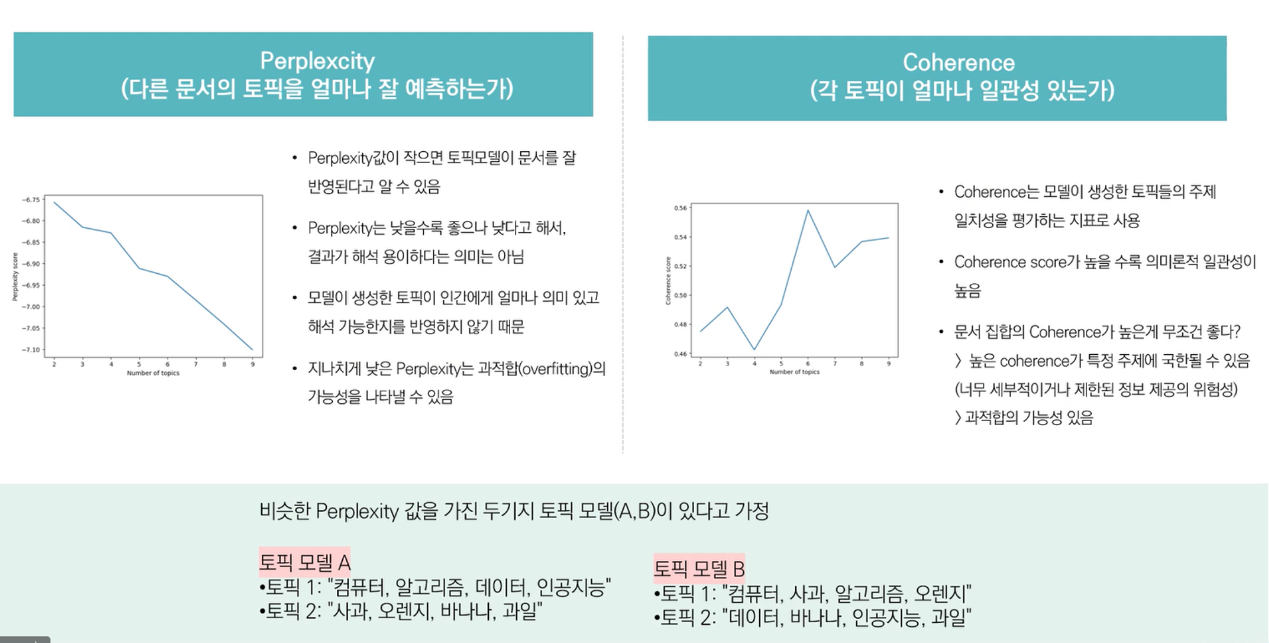
- 토픽개수 선정 기준 (잘 기억이 안나는데 여기서 말하는 클러스터수가 토픽개수라는 의미이지 않을까하는...)
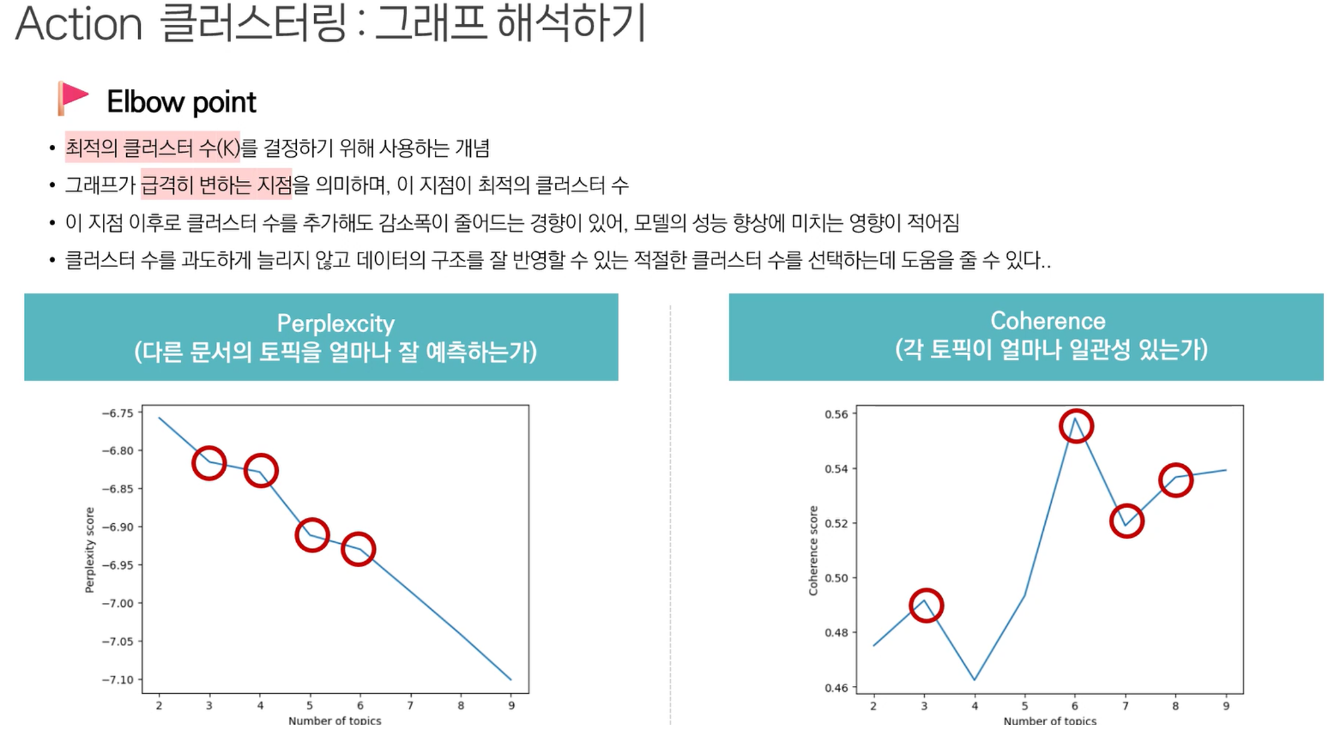

###### 2-1-1) Perplexity 그래프 만들기

In [81]:
# random_seed = 1 # (변경 옵션) LDA는 확률형 모델이라 난수 통제 필요. 임시적으로 1 지정
# perplex_values=[]

# # (변경 옵션) range(2,20)의 범위로 LDA 모델 생성 후 perplexity 값들 저장
# for i in range(2,20):
#     ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary, random_state=random_seed)
#     perp_v=ldamodel.log_perplexity(corpus) # 결과값
#     perplex_values.append(perp_v)

# # 시각화
# x= range(2,20)
# plt.plot(x, perplex_values)
# plt.xlabel('Number of topics')
# plt.ylabel('Perplexity score')

###### 2-1-2) Coherence 그래프 만들기 -> 시간이 상당히 소요되니 볼 필요 없으면 주석 처리 추천

In [83]:
# random_seed = 1 # (변경 옵션) LDA는 확률형 모델이라 난수 통제 필요. 임시적으로 1 지정
# cohearence_values=[]

# # (변경 옵션) range(2,10)의 범위로 LDA 모델 생성 후 coherence 값들 저장
# for i in range(2,10):
#     ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary)
#     cohearence_model=CoherenceModel(model=ldamodel, texts=all_documents, dictionary=dictionary, topn=i)
#     cohearence_score=cohearence_model.get_coherence()
#     cohearence_values.append(cohearence_score)

# # 시각화
# x=range(2,10)
# plt.plot(x, cohearence_values)
# plt.xlabel('Number of topics')
# plt.ylabel('Cohearence score')

##### 2-2) 선정한 토픽 개수로 Action넘버 매칭
- 해당 코드는 임의값으로 5를 선정

In [85]:
topic_n = 5 # (필수 변경 옵션) 선정한 토픽 개수
random_seed = 1
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = topic_n, id2word = dictionary, random_state = random_seed, passes = 5)

In [86]:
action_align=[]

for doc in tqdm(ldamodel.get_document_topics(corpus)):
    label=[]
    value=[]

    for score in doc:
        label.append(score[0])
        value.append(score[1]) # label 값, value값 분리

    max_index=np.argmax(value)
    action_n=label[max_index]
    action_align.append(action_n)

100%|██████████| 3978/3978 [00:00<00:00, 10975.51it/s]


In [87]:
ldamodel.get_document_topics(corpus)[0]

[(3, 0.9662716)]

In [88]:
df_cluster['action_cluster'] = action_align
# df_cluster

#### 3) LDA 시각화 (LDAvis)
- 원의 크기 : 토픽의 단어들이 얼마나 속해 있고 어떻게 분포 되어있는지
- 원의 거리 : 토픽 간의 유사성 (두 개의 원이 겹친다면 , 두 개의 토픽은 유사한 토픽이라는 의미)
- λ  =1 일수록,
토픽 별로 가장 자주 등장하는 단어들을 우선적으로 키워드로 선택한다는 의미
- λ = 0 일수록,
토픽 간에 차이가 많이 나는 단어를 선택한다는 의미 (해당 토픽에서 많이 등장한 단어)

In [90]:
prepared_data = gensimvis.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(prepared_data, 'ldavis_actor.html') # html로 저장
pyLDAvis.display(prepared_data)

##### 3-1 LDA 분석을 위한 후작업
- LDAvis(시각화 결과)와 LDA모델의 토픽 넘버가 다르기 때문에 이를 매칭하는 작업
- LDAvis 결과와 LDA모델의 결과를 보고 매칭
- 감성 분석을 위한 단계?인 듯하지만 일단 코드에 포함

In [92]:
# LDA 모델 토픽 넘버 확인
topics = ldamodel.show_topics(num_topics=-1, formatted=True)
topics

[(0,
  '0.033*"tv" + 0.026*"cool" + 0.025*"good" + 0.025*"lg" + 0.024*"ac" + 0.022*"remote" + 0.013*"time" + 0.012*"buy" + 0.011*"use" + 0.011*"also"'),
 (1,
  '0.033*"poor" + 0.031*"quality" + 0.025*"work" + 0.020*"sound" + 0.015*"picture" + 0.013*"cool" + 0.012*"tv" + 0.011*"get" + 0.011*"one" + 0.011*"well"'),
 (2,
  '0.033*"bad" + 0.029*"product" + 0.025*"machine" + 0.024*"installation" + 0.023*"wash" + 0.018*"flipkart" + 0.016*"get" + 0.016*"buy" + 0.014*"clothes" + 0.014*"day"'),
 (3,
  '0.076*"product" + 0.042*"money" + 0.034*"buy" + 0.029*"flipkart" + 0.024*"waste" + 0.023*"lg" + 0.020*"good" + 0.017*"bad" + 0.014*"value" + 0.014*"ac"'),
 (4,
  '0.060*"good" + 0.032*"quality" + 0.028*"nice" + 0.024*"wash" + 0.021*"machine" + 0.020*"tv" + 0.019*"picture" + 0.017*"sound" + 0.017*"product" + 0.014*"lg"')]

In [93]:
# LDAvis와 LDA모델의 결과를 비교하며 매칭
# 참고로 아래는 단순히 예시이기 때문에 엉망인 매칭입니다.
new_action_topic = []
for i in df_cluster.action_cluster :
    if i == 4 : # 처음에 설정한 액션 토픽 넘버
        n = 1 # vis에서 나온 토픽 넘버
    elif i == 1 :
        n = 2
    elif i == 0 :
        n = 3
    elif i == 2:
        n = 4
    else :
        n = 5
    new_action_topic.append(n)

# df_cluster['action_cluster'] = new_action_topic # 이건 감성 분석을 위한 단계 아닌가..?

#### 추가) 특정 키워드를 포함하는 텍스트 원문 찾기

In [95]:
# DataFrame에서 특정 키워드를 포함하는 원문들을 찾는 함수.
def df_find_keyword_in_texts(df, column_name, keyword, action_cluster):
    if(action_cluster=="all"):
        filtered_df = df[df[column_name].str.contains(keyword, na=False, case=False)]
        return filtered_df[[column_name]]
    else:
        action_filtered_df = df[df['action_cluster'] == int(action_cluster)]
        filtered_df = action_filtered_df[action_filtered_df[column_name].str.contains(keyword, na=False, case=False)]
        return filtered_df[[column_name]]

# 문자열 내 특정 키워드를 하이라이트하는 함수
def highlight_keyword(s, keyword):
    if isinstance(s, str):  # 문자열인지 확인
        # re.sub을 사용하여 대소문자 구분 없이 키워드를 하이라이트
        highlighted = re.sub(f'({keyword})', r'<span style="background-color: yellow">\1</span>', s, flags=re.IGNORECASE)
        return highlighted
    return s  # 문자열이 아니면 원본 반환

# DataFrame 내 모든 문자열에서 특정 키워드를 하이라이트하는 함수
def df_highlight_keyword(df, keyword):
    return df.style.format(lambda x: highlight_keyword(x, keyword))

In [169]:
# 찾고자 하는 키워드 선택
# 찾고자 하는 액션 클러스터 넘버 선택(단, 문자열 형태로. ex) "all", "1", "2", "3", "4")
keyword = "service" 
action_cluster_number = "all"

pd.set_option('display.max_colwidth', None) # 컬럼 너비 제한 해제
df_find_keywords = df_find_keyword_in_texts(df_cluster, "original", keyword, action_cluster_number) 
df_highlight_keyword(df_find_keywords, keyword)

,original
2,"If you want to buy a white showpiece for your bedroom then go ahead otherwise BIG NO. Worst service experience. Flipkart would not accept return/exchange if you need to. The indoor unit has serious water leakage issues, so this showpiece can be used as bedside shower."
6,"Worst service from flipkart and jeeves ,wrong instllation done of indoor and outdoor unit ,continuous water leakage from Indoor unit ,no service support as continously following up from day of installation ,still no positive response"
19,Product is very nice but service is not that good as my AC has cooling issue and not resolved by company or installation team..also known that the LG company and installation tema was different so ensure while installing
21,"Not a good product and installation by service partner is worst, installation tacnician is unexperienced . Thay made my new ac into old ac. Ac is not cooling room"
36,"Please don't buy any electronics from Flipkart, I got this AC and it never worked from day 1. They wouldn't help with replacement and just point you to LG customer service. I'm not buying anymore products from Flipkart."
40,Don't buy the AC from Flipkart. AC has been delivered on 2nd of June but No service engineer is coming for installation even after the elapse of 1 month. Customer care executives are non cooperative. It is not worth buying. I will rate it 0 star
41,Worst service by flipkart. My Ac delivered on 1st june and till now no installation done. Many follow up done by my side but no result. Flipkart team only giving fast comment daily. If someone want same pain which I get then go ahead or take another option.
54,Waste product from LG . Customer service is very bad. Cooling is zero I raised complaint even after the cooling is not good . Done buy this product from LG
64,"Waste of money, getting complain frequently, lg customer service not supportive etc..."
66,"very low cooling,next to zero cooling poor service by jeeves of flipkart poor service by flipkart"


In [171]:
df_find_keywords.value_counts()

original                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
very low cooling,next to zero cooling\r\npoor service by jeeves of flipkart\r\n\r\npoor service by flipkart                                                                                                                                                                                                                                                                                                                                                                             